<a href="https://colab.research.google.com/github/mukulre/Azure-Comm-Microsoft/blob/main/Energy_Consumption_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
df = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')

df.shape

<ipython-input-1-56df6da95a47>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
<ipython-input-1-56df6da95a47>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
<ipython-input-1-56df6da95a47>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt', sep=';',


(2075259, 7)

In [2]:
df.isnull().sum()

,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [3]:
df = df.fillna(df.mean())

<ipython-input-4-6fbdfc0ced7f>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(df.resample('M').mean().values[:, col])


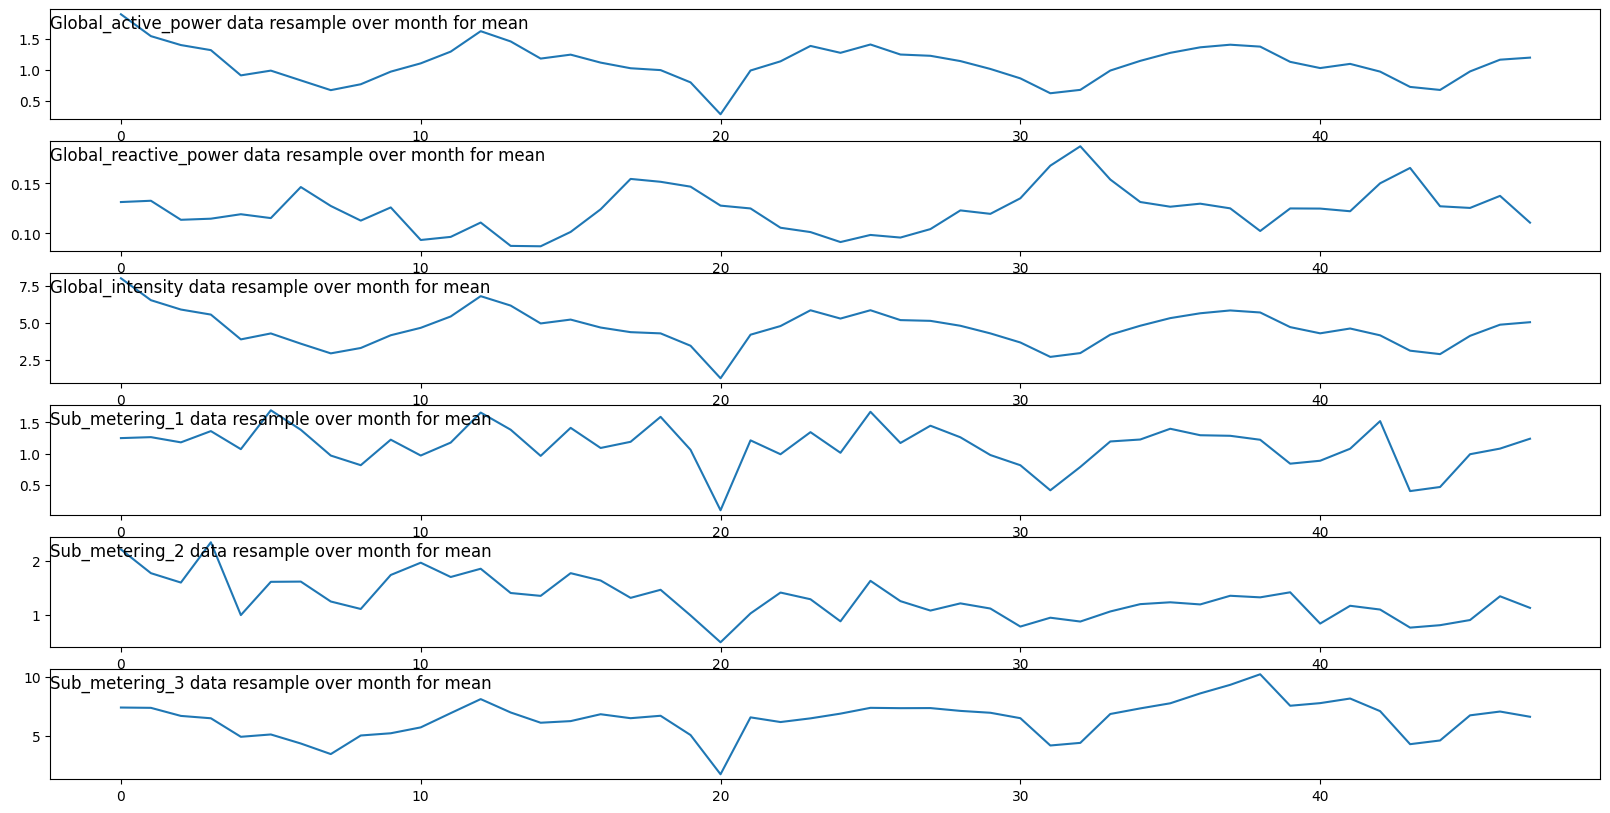

In [4]:
import matplotlib.pyplot as plt

i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('M').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

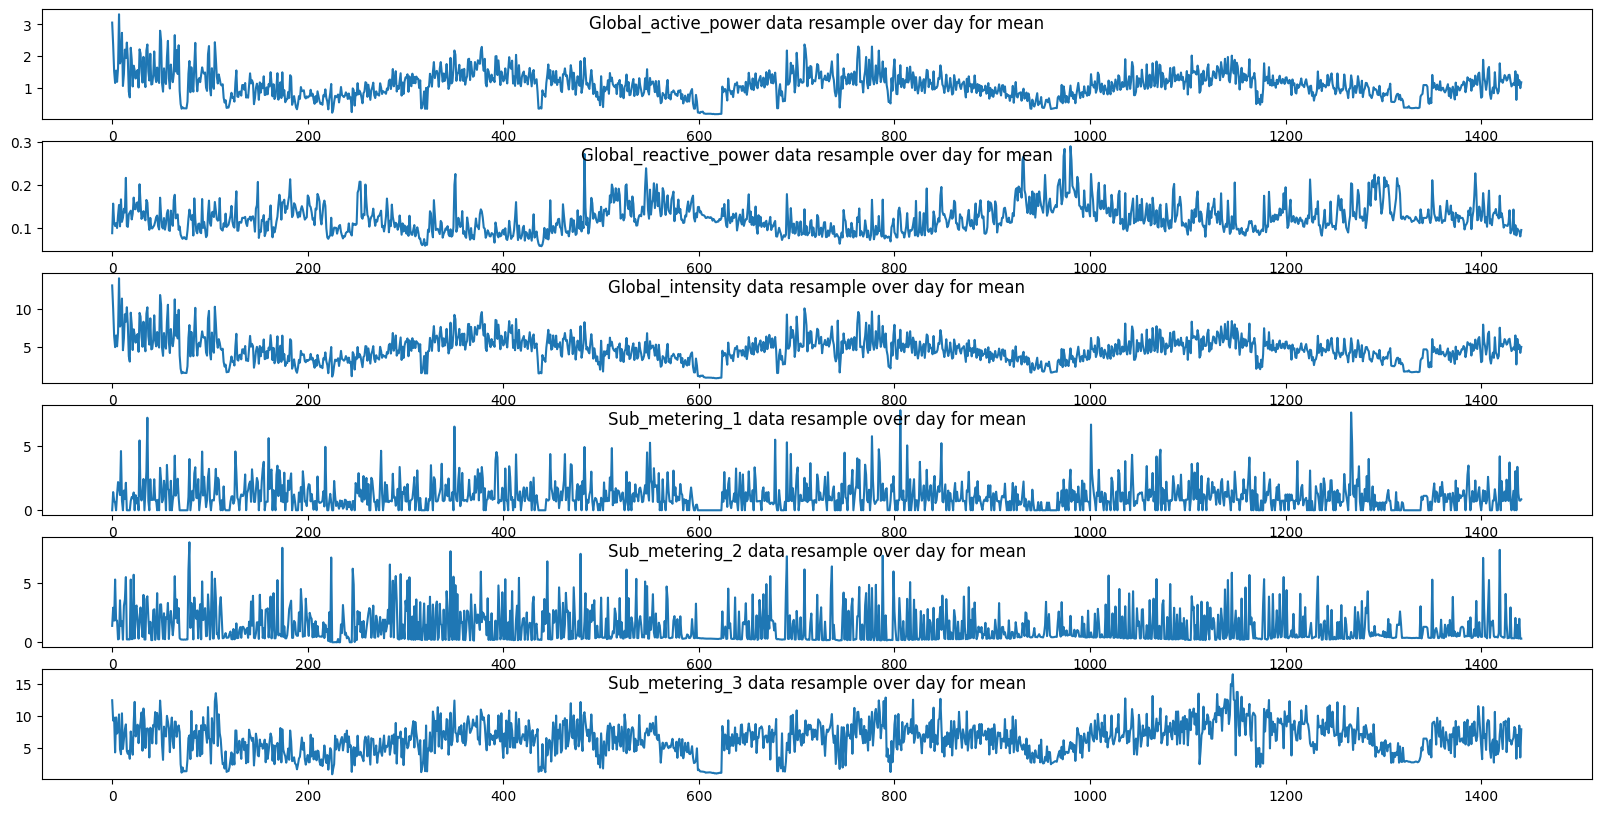

In [5]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

<ipython-input-6-95c62fd5628f>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(df.resample('H').mean().values[:, col])


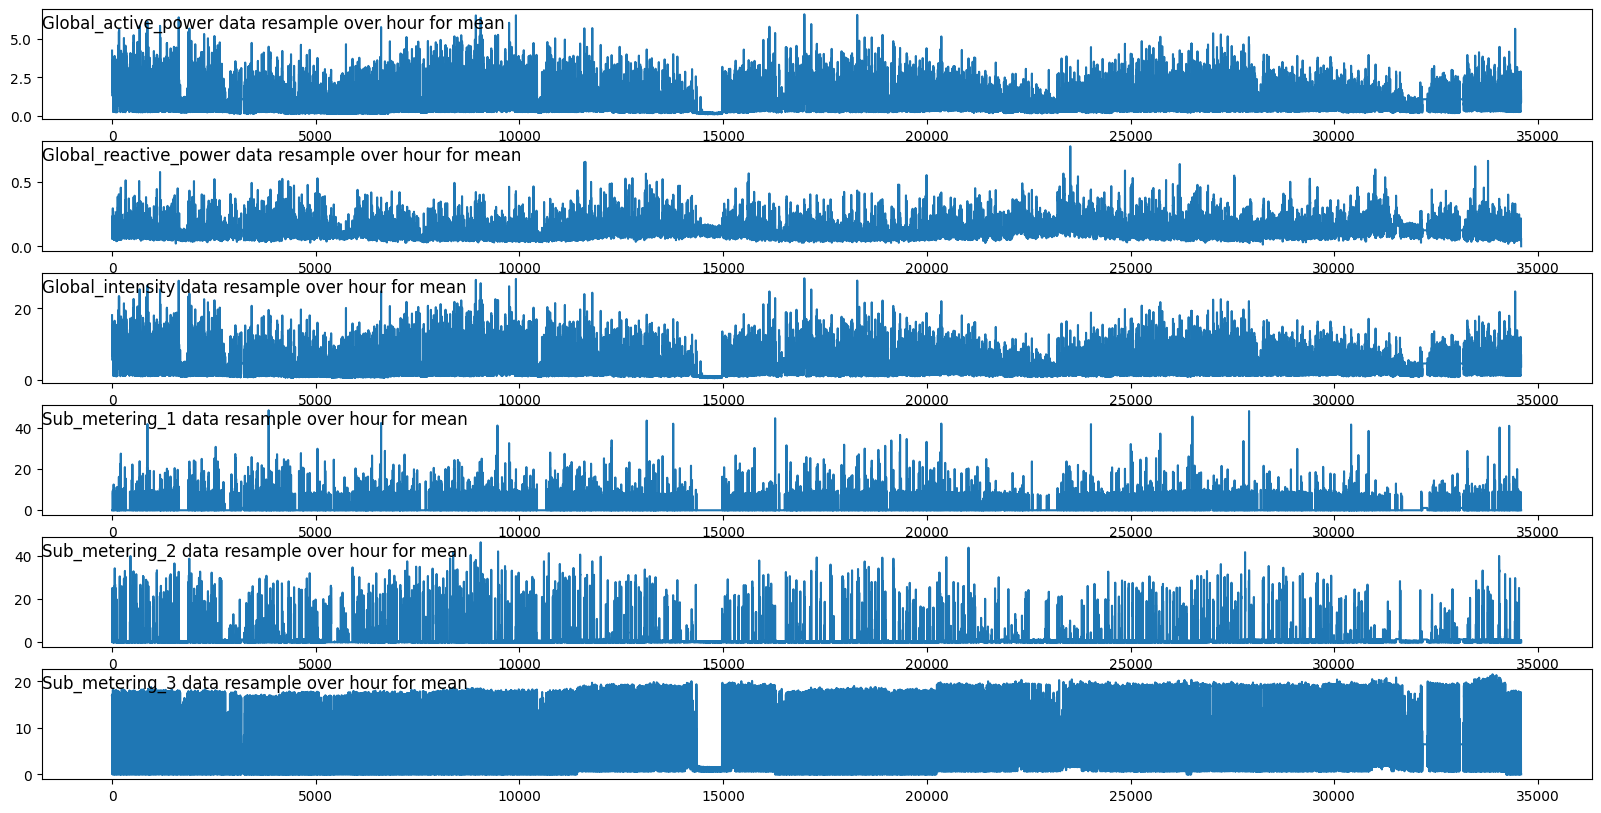

In [6]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('H').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

In [7]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [8]:
df_resample = df.resample('h').mean()
df_resample.shape

(34589, 7)

In [9]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

aa=[x for x in range(500)]
plt.figure(figsize=(25,10))
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 - 6s - 109ms/step - loss: 0.0275 - val_loss: 0.0105
Epoch 2/50
58/58 - 3s - 55ms/step - loss: 0.0149 - val_loss: 0.0100
Epoch 3/50
58/58 - 2s - 27ms/step - loss: 0.0140 - val_loss: 0.0098
Epoch 4/50
58/58 - 2s - 26ms/step - loss: 0.0135 - val_loss: 0.0097
Epoch 5/50
58/58 - 2s - 27ms/step - loss: 0.0130 - val_loss: 0.0095
Epoch 6/50
58/58 - 2s - 36ms/step - loss: 0.0126 - val_loss: 0.0094
Epoch 7/50
58/58 - 1s - 21ms/step - loss: 0.0123 - val_loss: 0.0094
Epoch 8/50
58/58 - 2s - 29ms/step - loss: 0.0121 - val_loss: 0.0093
Epoch 9/50
58/58 - 2s - 29ms/step - loss: 0.0120 - val_loss: 0.0093
Epoch 10/50
58/58 - 2s - 33ms/step - loss: 0.0119 - val_loss: 0.0092
Epoch 11/50
58/58 - 2s - 29ms/step - loss: 0.0118 - val_loss: 0.0092
Epoch 12/50
58/58 - 1s - 26ms/step - loss: 0.0118 - val_loss: 0.0092
Epoch 13/50
58/58 - 2s - 27ms/step - loss: 0.0118 - val_loss: 0.0092
Epoch 14/50
58/58 - 2s - 26ms/step - loss: 0.0118 - val_loss: 0.0091
Epoch 15/50
58/58 - 2s - 26ms/step - loss: 0.0117 - v